In [1]:
## Parameters for Pattern Lattice Builder
verbose     = True

## multiprocess
use_mp       = True
if use_mp:
    import os
    n_cores = max(1, round(os.cpu_count()/2) + 1)
else:
    n_cores = 1
print(f"n_cores: {n_cores}")

## set font for Japanese character display
use_multibyte_chars = False
print(f"use_multibyte_chars: {use_multibyte_chars}")

n_cores: 5
use_multibyte_chars: False


In [2]:
## select target file
from pathlib import Path
wd = Path("./data3-morphology")
target_files = list(wd.glob('*.txt')) + list(wd.glob('*.csv'))
import pprint as pp
pp.pprint(f"target files: {target_files}")

("target files: [PosixPath('data3-morphology/pl-sing-ring-bring-fight.csv'), "
 "PosixPath('data3-morphology/pl-sing-ring.csv'), "
 "PosixPath('data3-morphology/pl-sing-ring-bring.csv'), "
 "PosixPath('data3-morphology/pl-drink-ring.csv'), "
 "PosixPath('data3-morphology/pl-dig-dag.csv')]")


In [3]:
## select one target file
target_file  = target_files[-1]
print(f"target file: {target_file}")

target file: data3-morphology/pl-dig-dag.csv


In [4]:
## load data
## remove comment lines
comment_escapes  = [ '#', '%' ]
with open(target_file, 'r') as f:
    raw_lines = [ line.strip() for line in f.readlines() if len(line) > 0 and line[0] not in comment_escapes ]

## remove inline comments
check = True
lines = []
for line in raw_lines:
    body = [ ]
    for char in line:
        if char in comment_escapes:
            break
        else:
            body.append(char)
    t = "".join([ x.strip() for x in body ])
    lines.append(str(t))
print(f"lines: {lines}")

lines: ['d,a,g', 'd,a,g(g);e,r', 'd,i,g', 'd,i,g,s', 'd,i,g(g);e,r', 'd,i,g(g);i,n,g', 'd,u,g', 'd,a,g(g);i,n,g']


In [5]:
## lowercase
filtered_lines = [ line.lower() for line in lines ]

In [6]:
## filter lines by regex
pattern_filtering = True
filter_pattern = r'.*g.*'
if pattern_filtering:
    import re
    filtered_lines = [ line for line in lines if re.match(filter_pattern, line) ]
else:
    filtered_lines = lines
print(f"filtered_lines has {len(filtered_lines)} entries")
print(f"filtered_lines: {filtered_lines}")

filtered_lines has 8 entries
filtered_lines: ['d,a,g', 'd,a,g(g);e,r', 'd,i,g', 'd,i,g,s', 'd,i,g(g);e,r', 'd,i,g(g);i,n,g', 'd,u,g', 'd,a,g(g);i,n,g']


In [7]:
## set field separator
if str(target_file).endswith(".csv"):
    field_seps = r",;"
else:
    field_seps = r""
print(f"field_seps: '{field_seps}'")

field_seps: ',;'


In [8]:
## set phrase segmentation parameters
use_larger_segments = True
if use_larger_segments:
    sep2_is_suppressive = True
else:
    sep2_is_suppressive = False
print(f"sep2_is_suppressive: {sep2_is_suppressive}")

sep2_is_suppressive: True


In [9]:
filtered_lines

['d,a,g',
 'd,a,g(g);e,r',
 'd,i,g',
 'd,i,g,s',
 'd,i,g(g);e,r',
 'd,i,g(g);i,n,g',
 'd,u,g',
 'd,a,g(g);i,n,g']

In [ ]:
## split line into fields
import gPLB as plb
data = [ plb.segment_with_levels(line, seps = field_seps, sep2_is_suppressive = sep2_is_suppressive, split_hyphenation = False, uncapitalize = False, normalize = True) for line in filtered_lines ]
pp.pprint(f"data: {data}")

("data: [['dag'], ['dag(g)', 'er'], ['dig'], ['digs'], ['dig(g)', 'er'], "
 "['dig(g)', 'ing'], ['dug'], ['dag(g)', 'ing']]")


In [11]:
## filter lines by length
size_filtering = True
min_length =  2
max_length =  4
if size_filtering:
    data = [ item for item in data if min_length <= len(item) and len(item) <= max_length ]
else:
    data = data
print(f"data has {len(data)} entries")

import pprint as pp
pp.pprint(data)

data has 4 entries
[['dag(g)', 'er'], ['dig(g)', 'er'], ['dig(g)', 'ing'], ['dag(g)', 'ing']]


In [12]:
## get graph_layout parameters
n_items    = len(data)
max_n_segs = max(map(len, data))
print(f"max_n_segs: {max_n_segs}, n_items: {n_items}")

max_n_segs: 2, n_items: 4


In [13]:
## install required packages
#!conda install matplotlib multiprocess networkx -y

In [14]:
## parameters for PLB
gap_marks      = [ "…", "_" ]
gap_mark       = gap_marks[0]
tracer         = "~"

## if instantiation check is reflexive
reflexive      = True

## if node pooling is reductive
reductive      = True

## if robust Z-score is used instead of normal Z-score
use_robust_zscore   = True

## select the bases of z-scores: link sources or link targets
zscores_from_targets = False

In [15]:
## settings for font
import matplotlib
from matplotlib import font_manager as Font_manager
if use_multibyte_chars:
    ## select font
    multibyte_font_names = [    "IPAexGothic",  # 0 Multi-platform font
                                "Hiragino sans" # 1 Mac only
                            ]
    multibyte_font_name  = multibyte_font_names[0]
    ## tell where target fonts are
    system_font_dir = "/System/Library/Fonts/"
    user_font_dir = "/Library/Fonts/"
    # use the version installed via TeXLive
    user_font_dir2 = "/usr/local/texlive/2013/texmf-dist/fonts/truetype/public/ipaex/"
    if multibyte_font_name == "IPAexGothic":
        try:
            Font_manager.fontManager.addfont(f"{user_font_dir}ipaexg.ttf")
        except FileNotFoundError:
            Font_manager.fontManager.addfont(f"{user_font_dir2}ipaexg.ttf")
    elif multibyte_font_name == "Hiragino sans":
        Font_manager.fontManager.addfont(f"{system_font_dir}ヒラギノ角ゴシック W0.ttc")
    ## check result
    matplotlib.rc('font', family = multibyte_font_name)
else:
    multibyte_font_name = None
    matplotlib.rcParams['font.family'] = "Sans-serif"
##
print(f"multibyte_font_name: {multibyte_font_name}")
print(f"matplotlib.rcParams['font.family']: {matplotlib.rcParams['font.family']}")    

multibyte_font_name: None
matplotlib.rcParams['font.family']: ['Sans-serif']


In [16]:
#!conda install multiprocess networkx seaborn -y

In [ ]:
## build pattern lattices from data
import gPLB as plb
PLs = [ ]
for item in data:
    ## build a Patter for each item
    pat    = plb.Pattern(item, gap_mark, tracer)
    ## run through generality levels
    for generality in range(0, 3):
        patlat = plb.PatternLattice(pat, reflexive = reflexive, generality = generality)
        if verbose:
            print(patlat)
        PLs.append(patlat)

PatternLattice ([Pattern ([('dag(g)', ['dag(g)']), ('er', ['er'])]), Pattern ([('dag(g)', ['dag(g)']), ('…', ['er'])]), Pattern ([('…', ['dag(g)']), ('er', ['er'])]), Pattern ([('…', ['dag(g)']), ('…', ['er'])])])
PatternLattice ([Pattern ([('dag(g)', ['dag(g)']), ('er', ['er'])]), Pattern ([('dag(g)', ['dag(g)']), ('…', ['er'])]), Pattern ([('…', ['dag(g)']), ('er', ['er'])]), Pattern ([('…', ['dag(g)']), ('…', ['er'])])])
PatternLattice ([Pattern ([('dag(g)', ['dag(g)']), ('er', ['er'])]), Pattern ([('dag(g)', ['dag(g)']), ('…', ['er'])]), Pattern ([('…', ['dag(g)']), ('er', ['er'])]), Pattern ([('…', ['dag(g)']), ('…', ['er'])])])
PatternLattice ([Pattern ([('dig(g)', ['dig(g)']), ('er', ['er'])]), Pattern ([('dig(g)', ['dig(g)']), ('…', ['er'])]), Pattern ([('…', ['dig(g)']), ('er', ['er'])]), Pattern ([('…', ['dig(g)']), ('…', ['er'])])])
PatternLattice ([Pattern ([('dig(g)', ['dig(g)']), ('er', ['er'])]), Pattern ([('dig(g)', ['dig(g)']), ('…', ['er'])]), Pattern ([('…', ['dig(g)

In [18]:
## print forms
print_forms = True
seg_joint = ", "
if print_forms:
    print(f"skippy n-grams of the merged lattice")
    for i, patlat in enumerate(PLs):
        for j, node in enumerate(patlat.nodes):
            print(f"patlat{i+1:02d}.node{j+1:03d}: {seg_joint.join(node.get_form())}")

skippy n-grams of the merged lattice
patlat01.node001: dag(g), er
patlat01.node002: dag(g), …
patlat01.node003: …, er
patlat01.node004: …, …
patlat02.node001: dag(g), er
patlat02.node002: dag(g), …
patlat02.node003: …, er
patlat02.node004: …, …
patlat03.node001: dag(g), er
patlat03.node002: dag(g), …
patlat03.node003: …, er
patlat03.node004: …, …
patlat04.node001: dig(g), er
patlat04.node002: dig(g), …
patlat04.node003: …, er
patlat04.node004: …, …
patlat05.node001: dig(g), er
patlat05.node002: dig(g), …
patlat05.node003: …, er
patlat05.node004: …, …
patlat06.node001: dig(g), er
patlat06.node002: dig(g), …
patlat06.node003: …, er
patlat06.node004: …, …
patlat07.node001: dig(g), ing
patlat07.node002: dig(g), …
patlat07.node003: …, ing
patlat07.node004: …, …
patlat08.node001: dig(g), ing
patlat08.node002: dig(g), …
patlat08.node003: …, ing
patlat08.node004: …, …
patlat09.node001: dig(g), ing
patlat09.node002: dig(g), …
patlat09.node003: …, ing
patlat09.node004: …, …
patlat10.node001: dag

In [19]:
## graph layout selection
graph_layouts = [   'Multi_partite', # 0
                    'Graphviz', # 1
                    'Spring', # 2
                    'Planar', # 3
                    'Circular', # 4
                    'Shell', # 5
                    'Spectral', # 6
                    'Kamada_Kawai', # 7
                    'Fruchterman_Reingold', # 8
                    'ARF', # 9
                    'Breadth-First Search', # 10
                 ]
#
graph_layout = graph_layouts[0]
print(f"graph_layout: {graph_layout}")

##
MPG_keys = ['gap_size', 'rank']
MPG_key  = MPG_keys[0]
print(f"MPG_key: {MPG_key}")

graph_layout: Multi_partite
MPG_key: gap_size


In [20]:
#!conda install networkx matplotlib -y 

In [21]:
#!conda install PyQt5 -y # fails
#!pip install -U PyQt5
#!conda update conda -y

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 8
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dag(g), er']


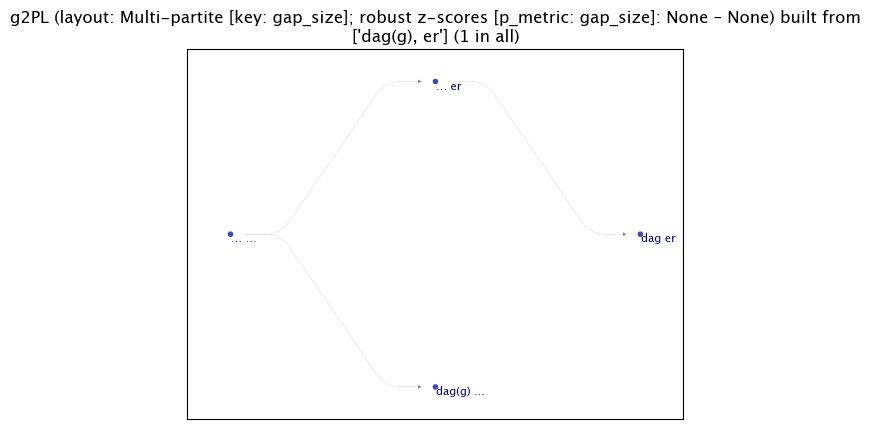

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 8
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dag(g), er']


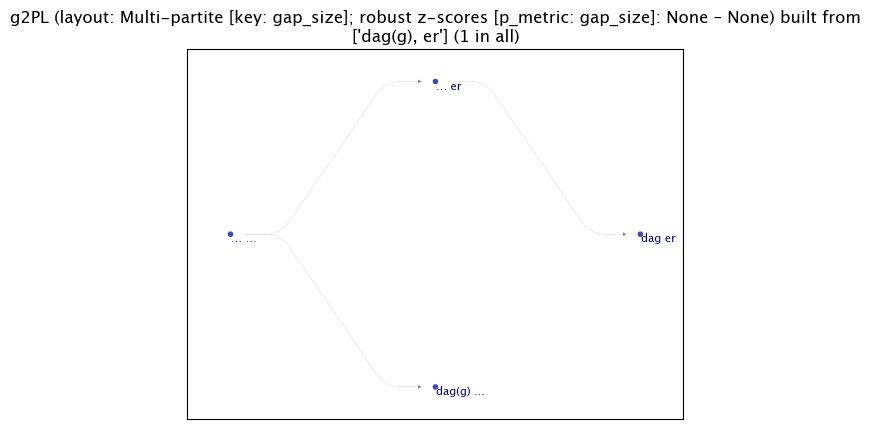

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 8
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dag(g), er']


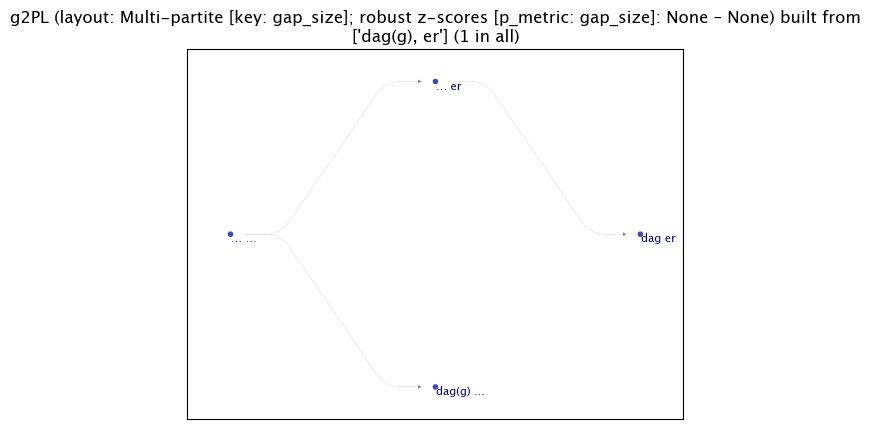

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 8
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dig(g), er']


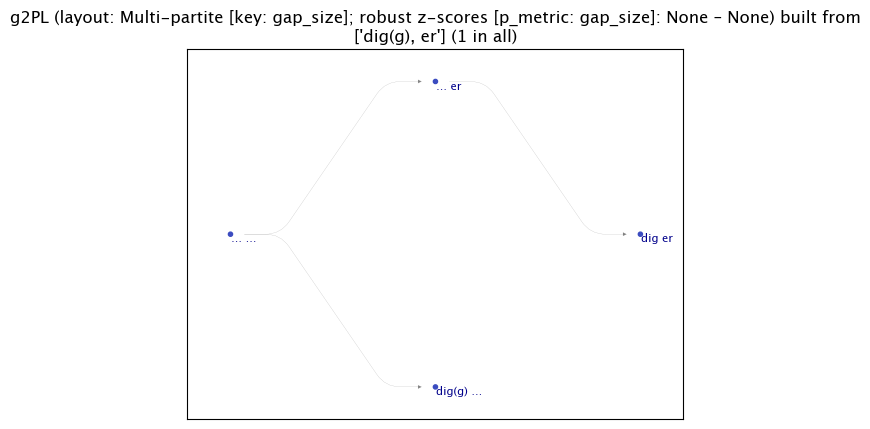

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 8
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dig(g), er']


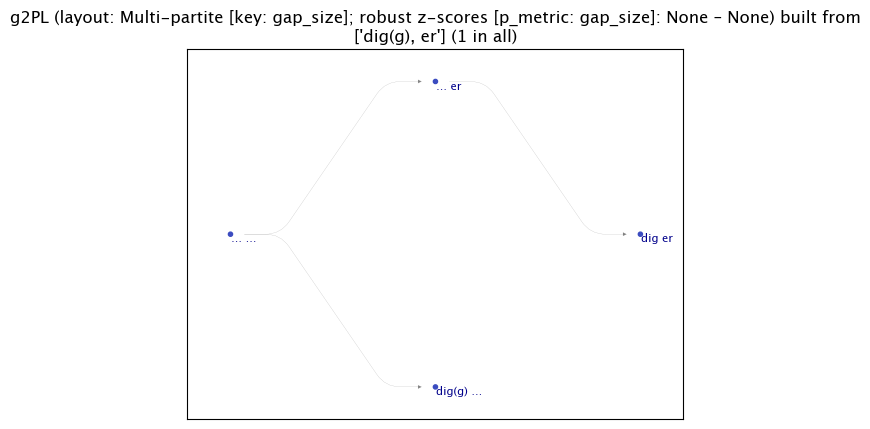

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 8
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dig(g), er']


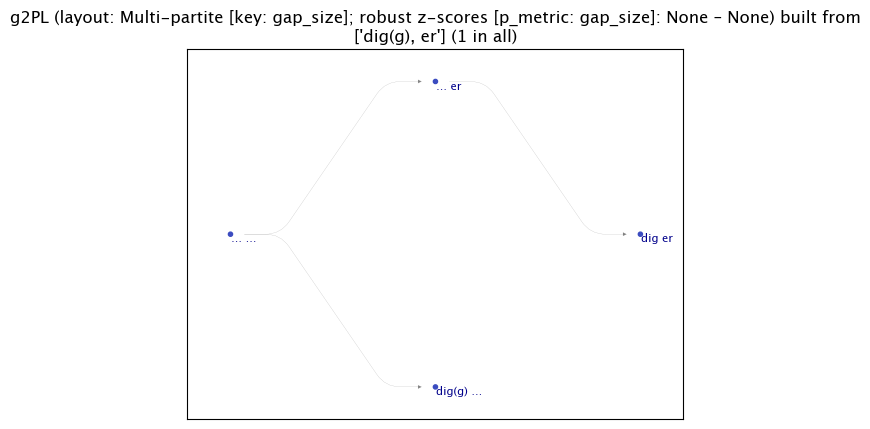

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 9
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dig(g), ing']


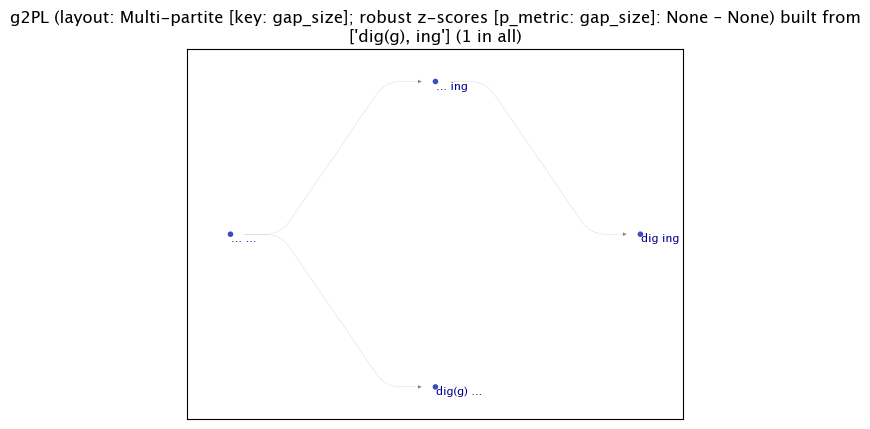

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 9
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dig(g), ing']


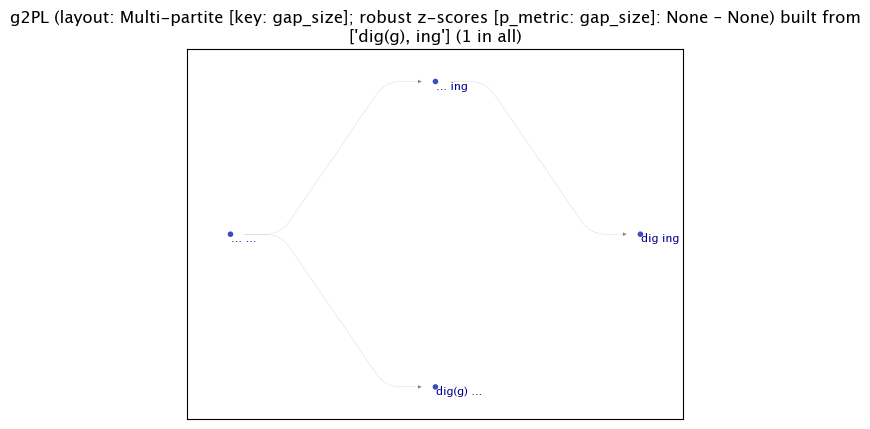

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 9
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dig(g), ing']


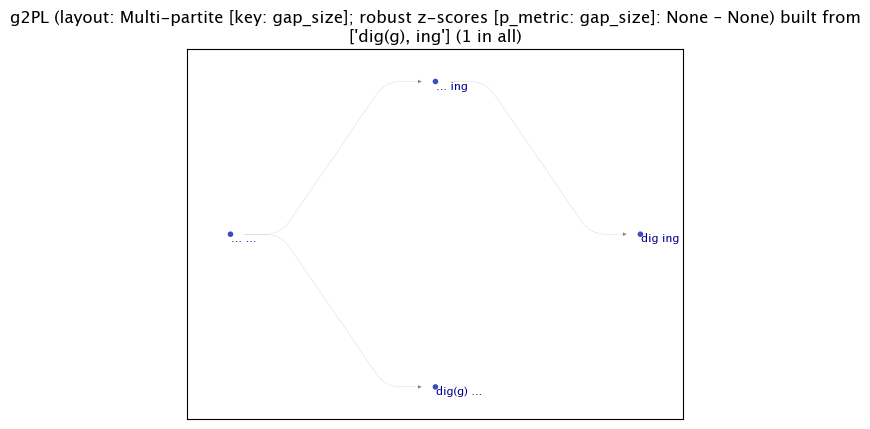

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 9
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dag(g), ing']


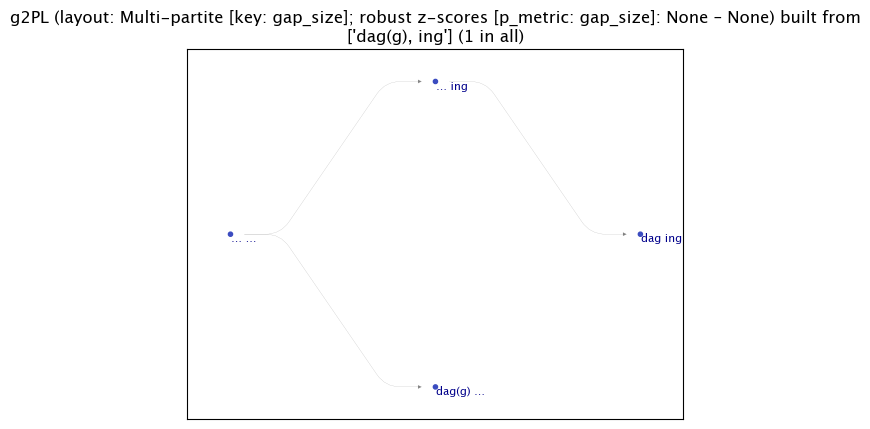

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 9
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dag(g), ing']


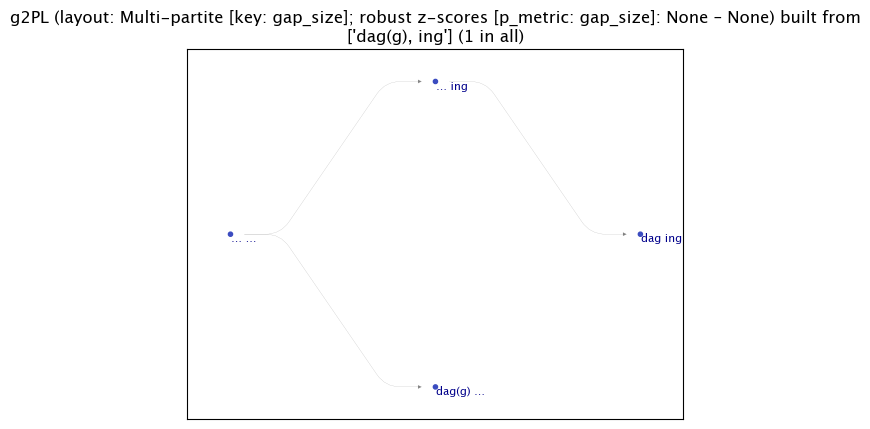

#pruned/ignored 0 nodes
#n_instances: 1
#max_instance_n_segs: 2
#max_instance_size: 9
#fig_size: None
#label_size: 8
#node_size: 9
#instance_labels 1: ['dag(g), ing']


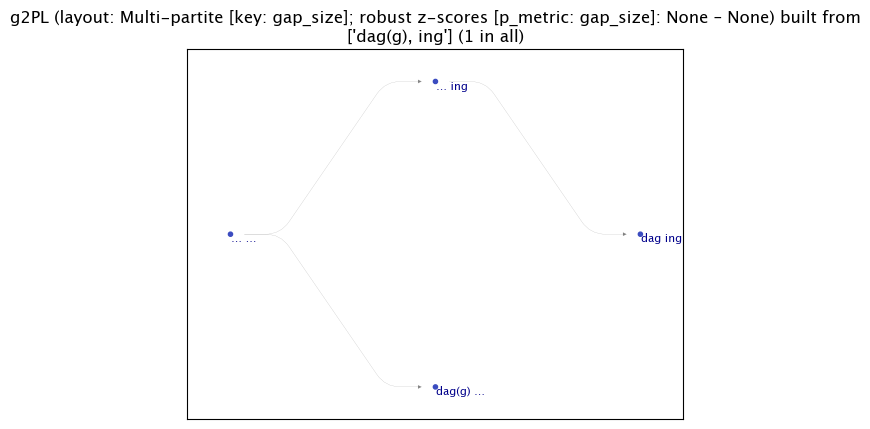

In [22]:
for PL in PLs:
    PL.draw_network (graph_layout, MPG_key, draw_inline = True, auto_figsizing = False, generality = generality, zscores_from_targets = zscores_from_targets, font_name = multibyte_font_name)